
# Michigan QCEW Employment — Forecast Comparison (Moody vs BLS)

This notebook compares **Moody's** and **BLS** forecast extensions applied to **Michigan QCEW** employment.
It plots **historical QCEW** (solid) and **forecast extensions** (Moody = dashed, BLS = dotted) with the forecast
period shaded.

**Inputs** (from `scripts/apply_growth_to_qcew.py`):
- `data/processed/mi_qcew_stage_employment_timeseries_extended_compare.csv`
- `data/processed/mi_qcew_segment_employment_timeseries_extended_compare.csv`


In [1]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def find_repo_root(markers=("data", "scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_PROCESSED = REPO_ROOT / "data" / "processed"
FIG_DIR = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

STAGE_CMP = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_extended_compare.csv"
SEG_CMP   = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_extended_compare.csv"

for p in (STAGE_CMP, SEG_CMP):
    if not p.exists():
        raise FileNotFoundError(f"Missing input: {p}. Run scripts/apply_growth_to_qcew.py first.")


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition


In [2]:

stage = pd.read_csv(STAGE_CMP)
seg   = pd.read_csv(SEG_CMP)

for df in (stage, seg):
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["employment_qcew"] = pd.to_numeric(df["employment_qcew"], errors="coerce")
    if "forecast_source" not in df.columns:
        df["forecast_source"] = None
    if "value_type" not in df.columns:
        df["value_type"] = "QCEW"

if "segment_name" not in seg.columns and "segment_label" in seg.columns:
    seg = seg.rename(columns={"segment_label": "segment_name"})

YR_MIN, YR_MAX = 2001, 2034
stage = stage.dropna(subset=["year"]).copy()
seg   = seg.dropna(subset=["year"]).copy()
stage["year"] = stage["year"].astype(int)
seg["year"]   = seg["year"].astype(int)

stage = stage[(stage["year"] >= YR_MIN) & (stage["year"] <= YR_MAX)].copy()
seg   = seg[(seg["year"]   >= YR_MIN) & (seg["year"]   <= YR_MAX)].copy()

stage_order = ["Upstream", "OEM", "Downstream"]
if "stage" in stage.columns:
    stage["stage"] = pd.Categorical(stage["stage"], categories=stage_order, ordered=True)

print("Stage years:", stage["year"].min(), "–", stage["year"].max())
print("Seg years  :", seg["year"].min(),   "–", seg["year"].max())


Stage years: 2001 – 2034
Seg years  : 2001 – 2034


In [3]:

def _forecast_start_year(df_group):
    s = df_group.loc[df_group["value_type"].eq("Forecast"), "year"]
    return int(s.min()) if not s.empty else None

def _plot_group_compare(sub, title, out_png, figsize=(12,6)):
    if sub.empty:
        print(f"[skip] No data: {title}")
        return

    fig, ax = plt.subplots(figsize=figsize)

    hist = sub[sub["value_type"].eq("QCEW")]
    if not hist.empty:
        hist = hist.sort_values("year")
        ax.plot(hist["year"], hist["employment_qcew"], label="QCEW (historical)", linestyle="-", linewidth=2)

    for source, ls in [("Moody", "--"), ("BLS", ":")]:
        fsub = sub[(sub["value_type"].eq("Forecast")) & (sub["forecast_source"].eq(source))].sort_values("year")
        if not fsub.empty:
            ax.plot(fsub["year"], fsub["employment_qcew"], label=f"{source} forecast", linestyle=ls, linewidth=2)

    fstart = _forecast_start_year(sub)
    if fstart is not None and fstart <= sub["year"].max():
        ax.axvspan(fstart, sub["year"].max(), alpha=0.12, zorder=0)
        patch = Patch(alpha=0.12, label="Forecast window")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch); labels.append("Forecast window")
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    ax.set_xlim(sub["year"].min(), sub["year"].max())
    ax.set_xlabel("Year")
    ax.set_ylabel("Employment (QCEW)")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {out_png}")
    plt.show()
    plt.close(fig)


## Stages — Michigan QCEW with Moody vs BLS forecasts (2001–2034)

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_stage_upstream_compare_2001_2034.png


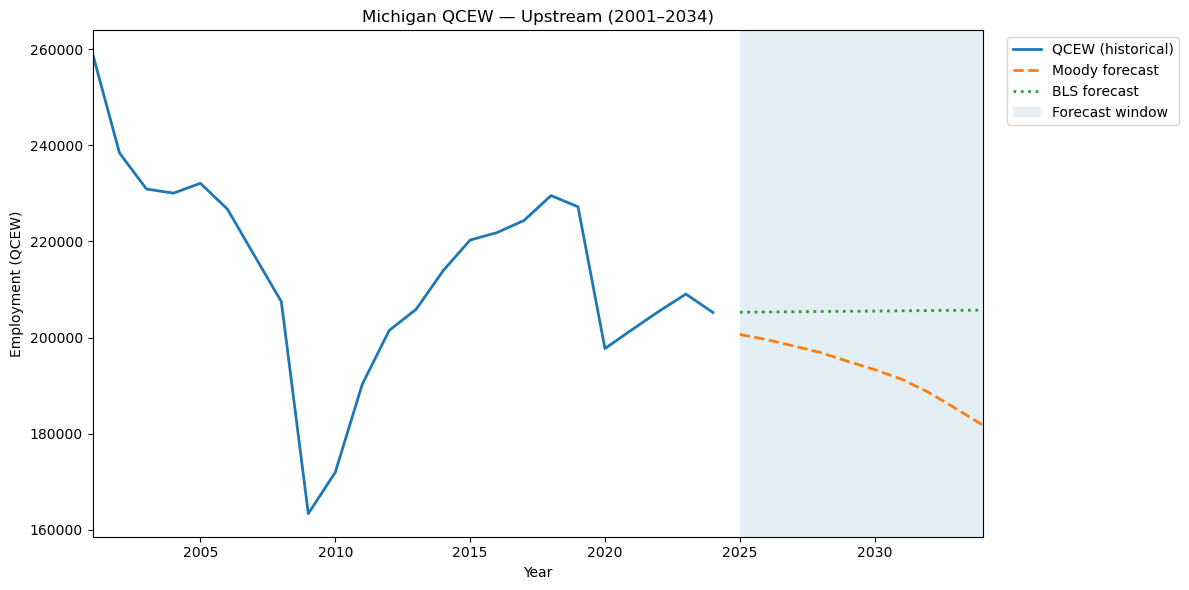

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_stage_oem_compare_2001_2034.png


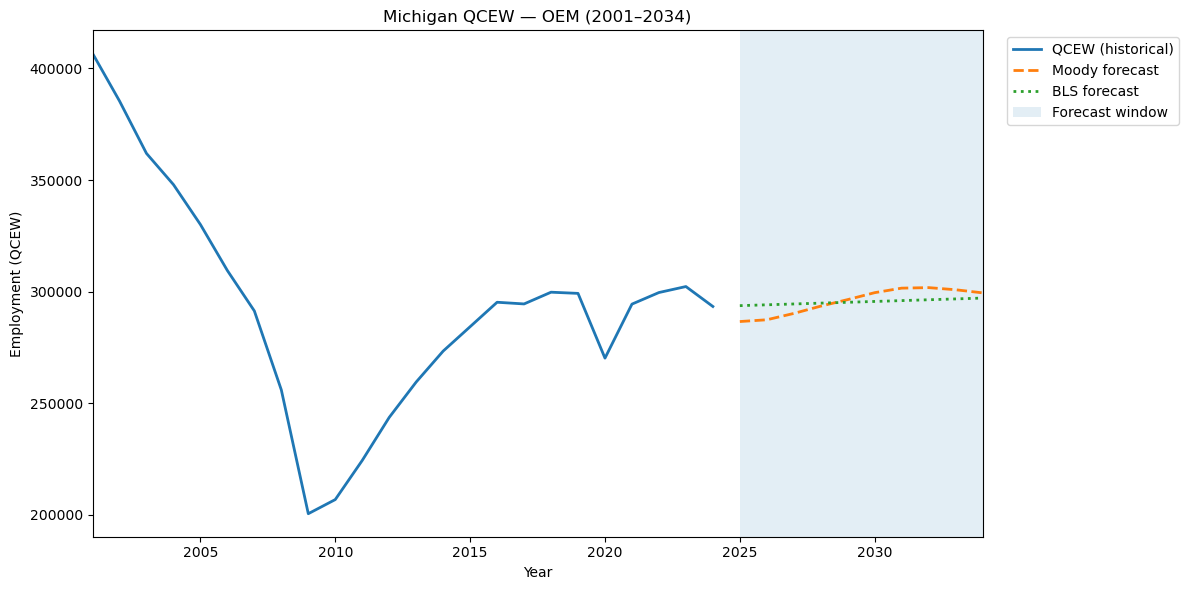

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_stage_downstream_compare_2001_2034.png


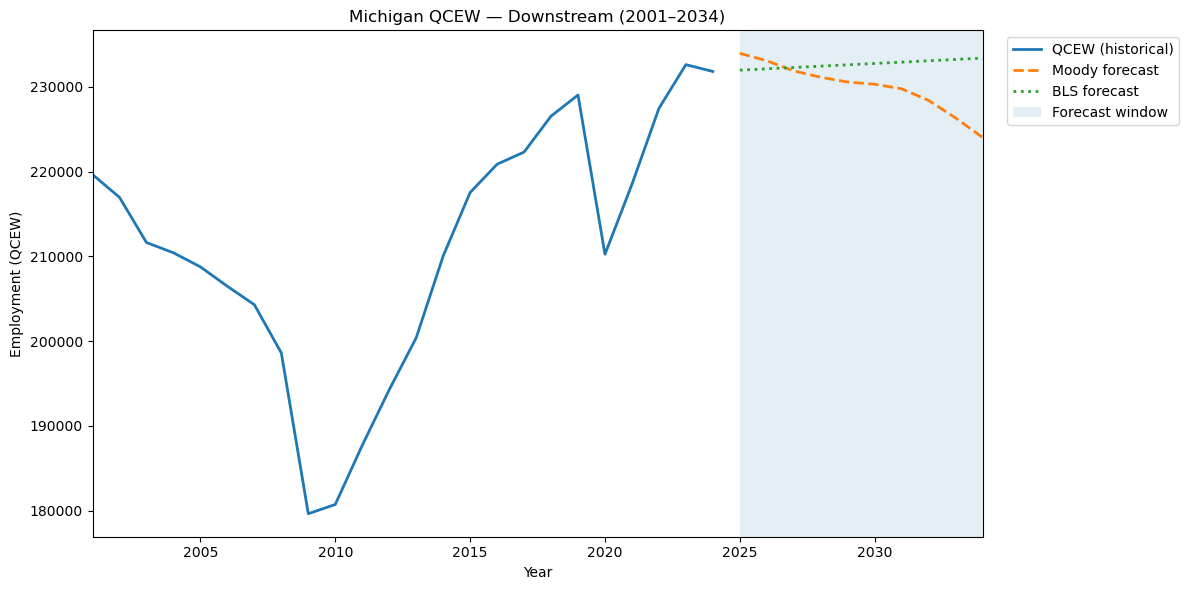

In [4]:

for st in ["Upstream", "OEM", "Downstream"]:
    sub = stage[stage["stage"].astype(str).eq(st)].copy()
    if sub.empty:
        continue
    _plot_group_compare(
        sub=sub,
        title=f"Michigan QCEW — {st} (2001–2034)",
        out_png=FIG_DIR / f"mi_qcew_stage_{st.lower()}_compare_2001_2034.png",
        figsize=(12,6)
    )


## Segments — Michigan QCEW with Moody vs BLS forecasts (2001–2034)

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_1_compare_2001_2034.png


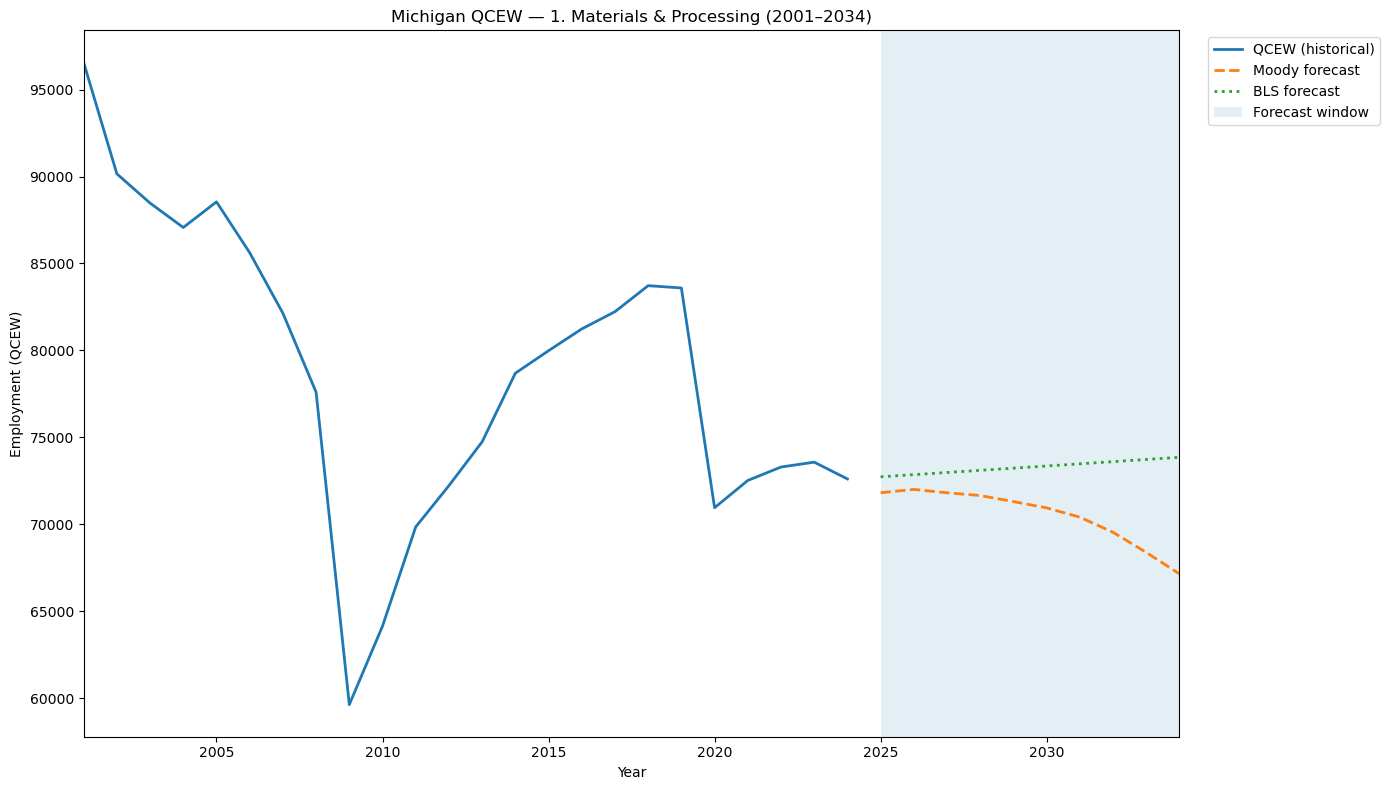

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_2_compare_2001_2034.png


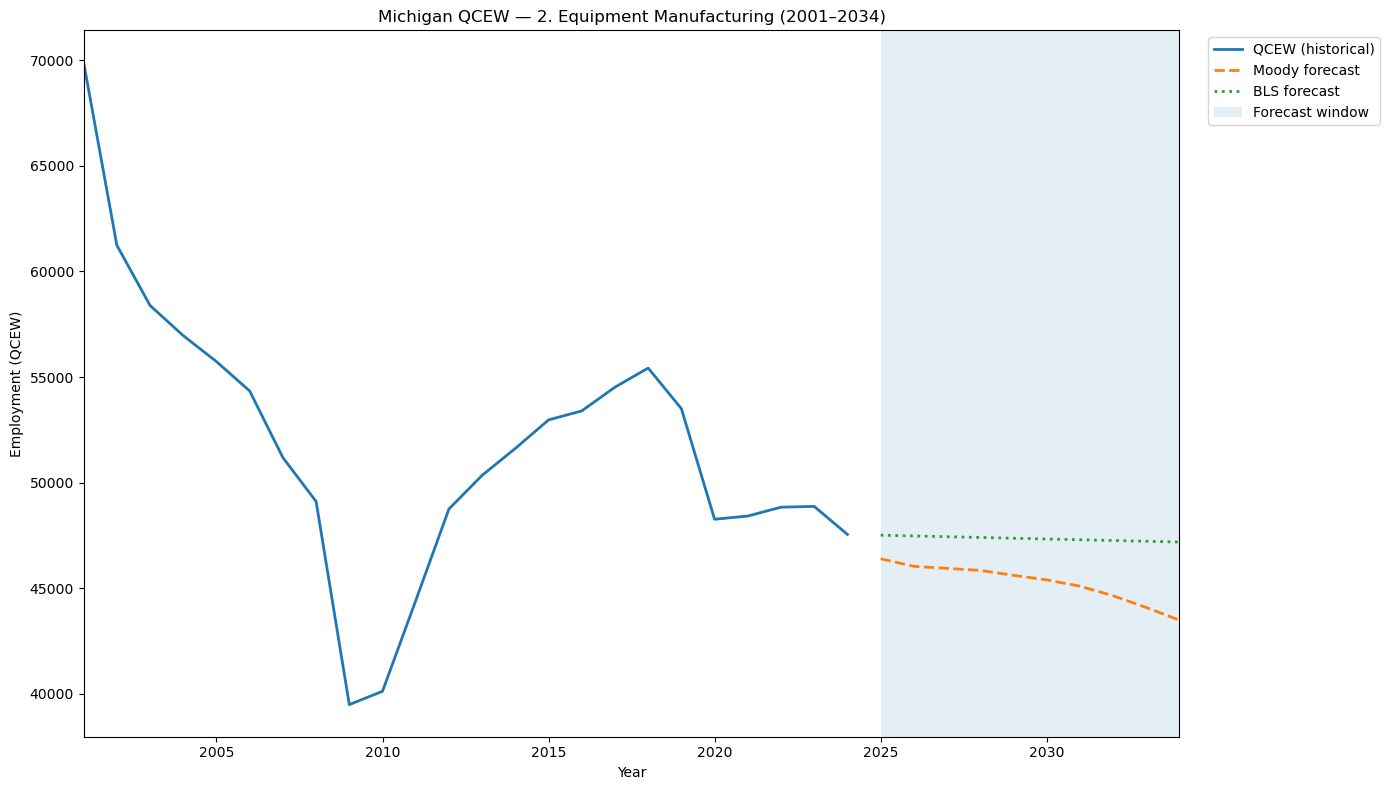

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_3_compare_2001_2034.png


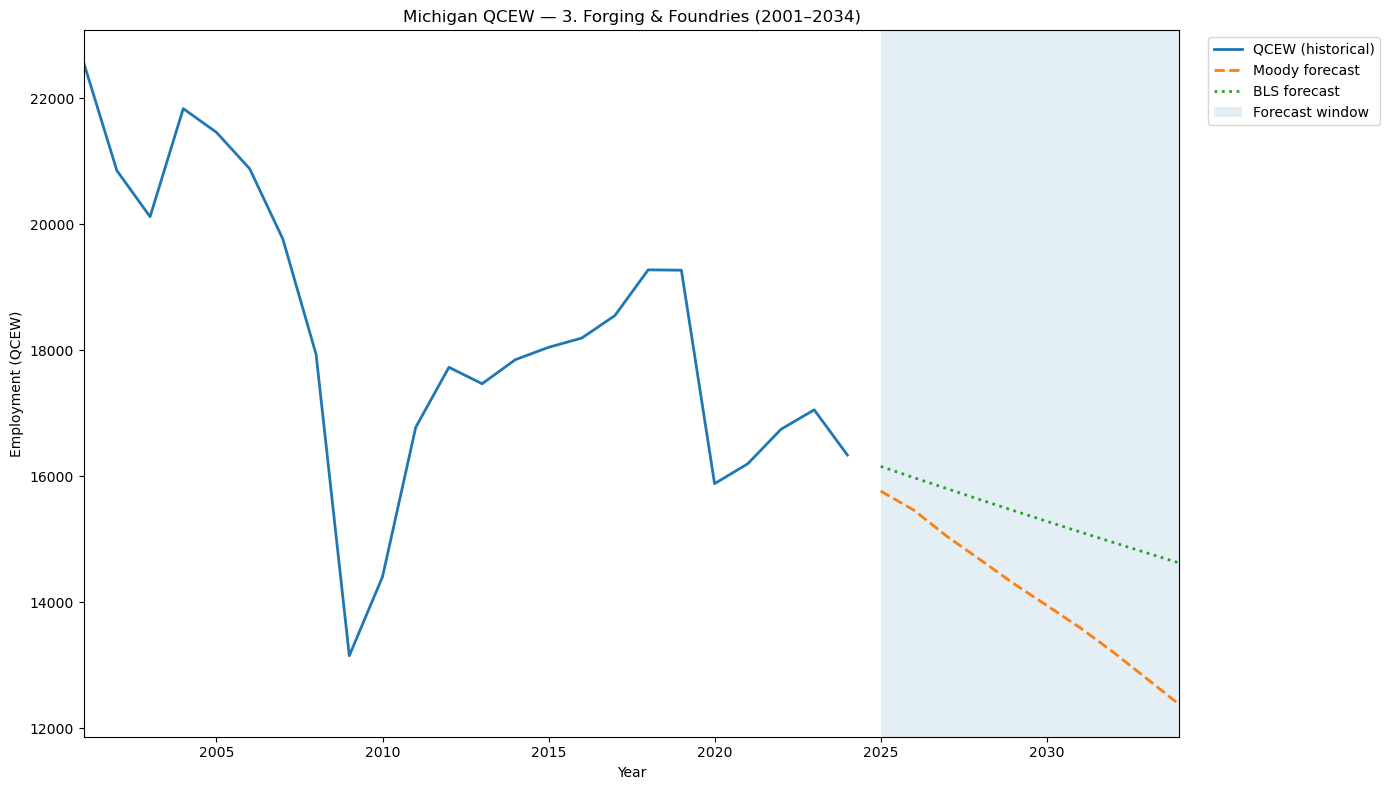

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_4_compare_2001_2034.png


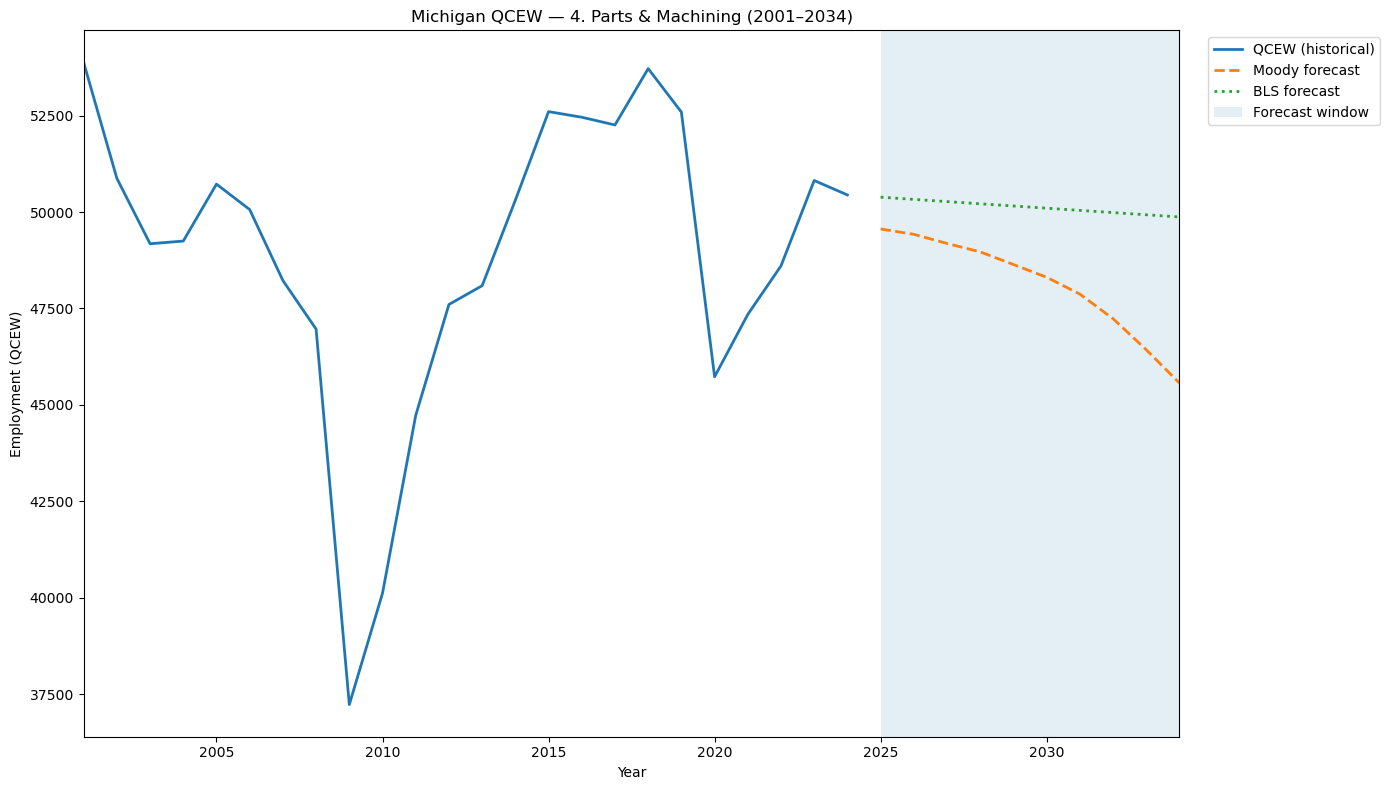

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_5_compare_2001_2034.png


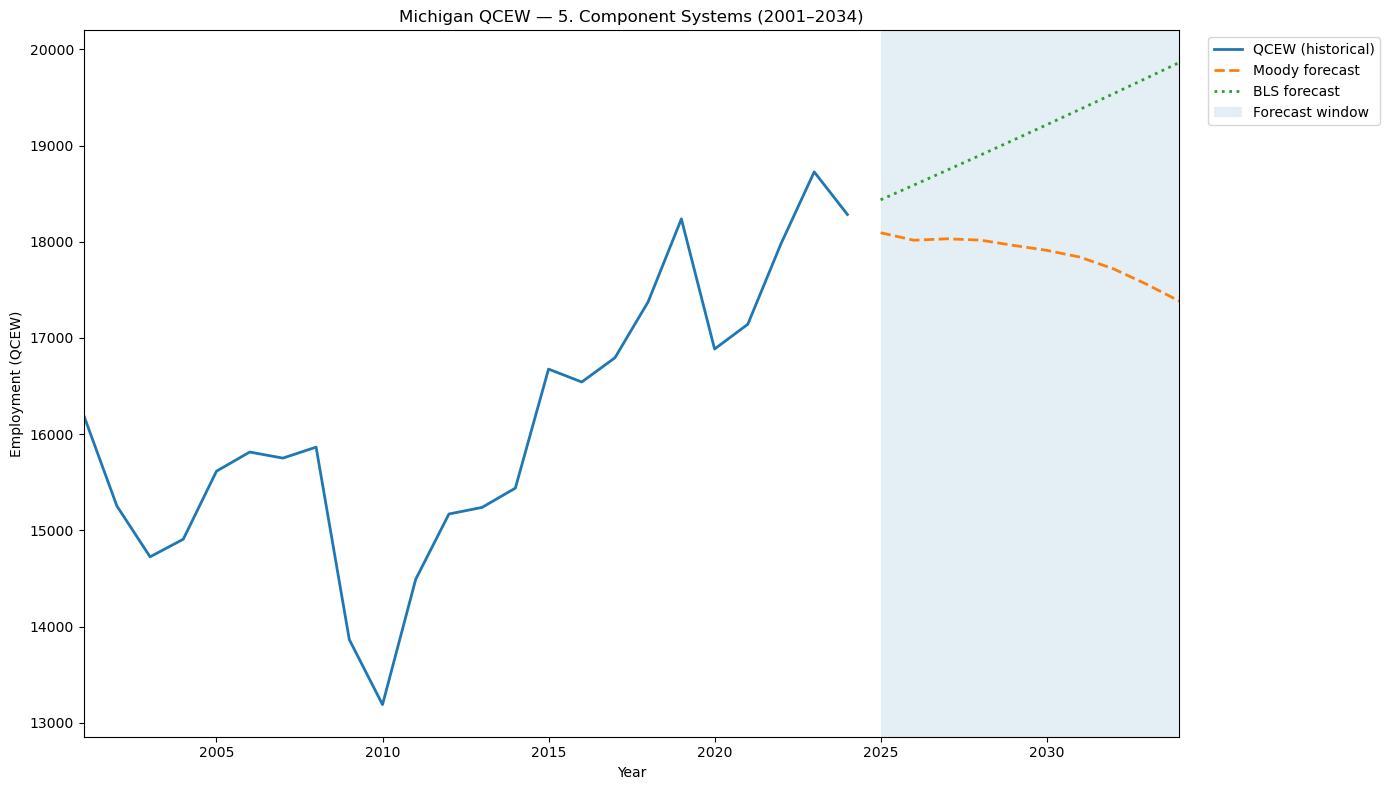

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_6_compare_2001_2034.png


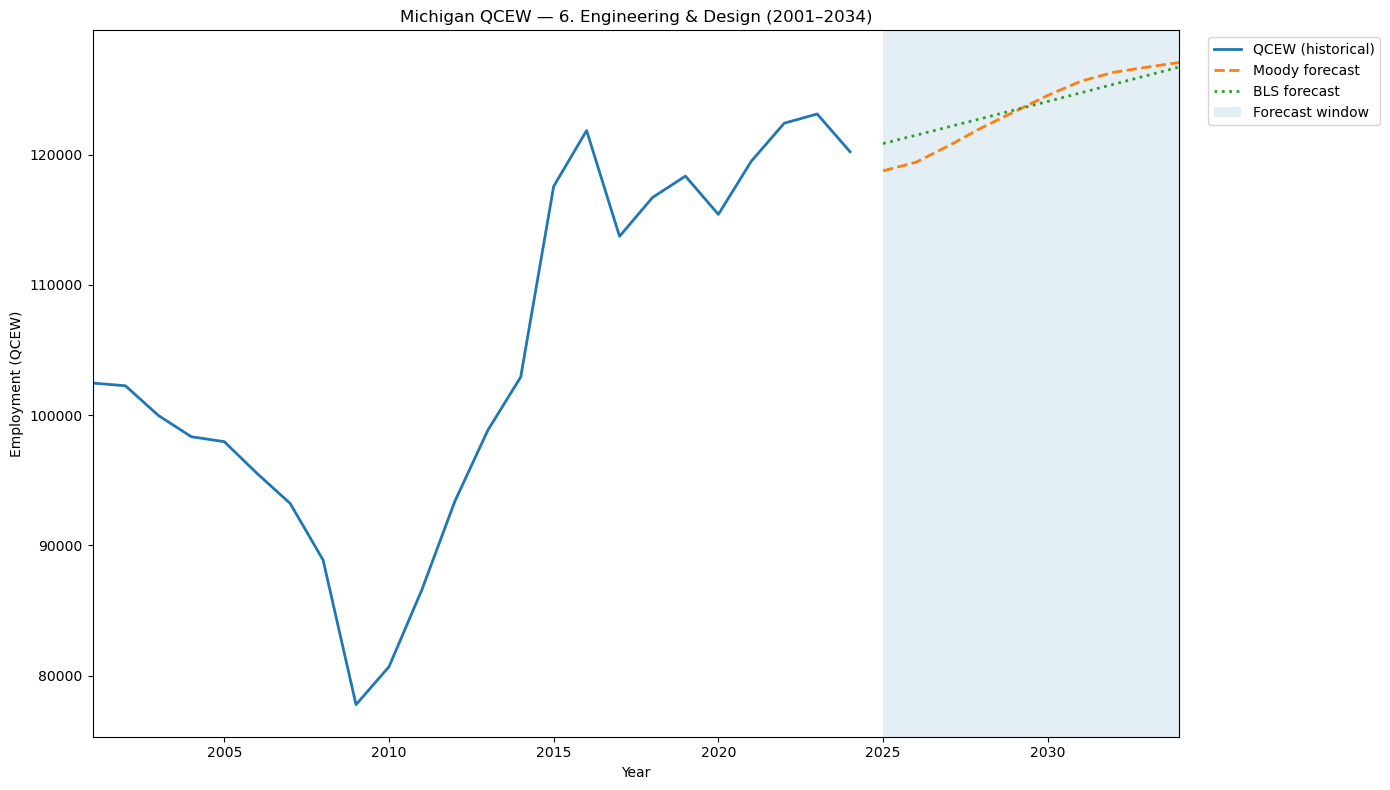

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_7_compare_2001_2034.png


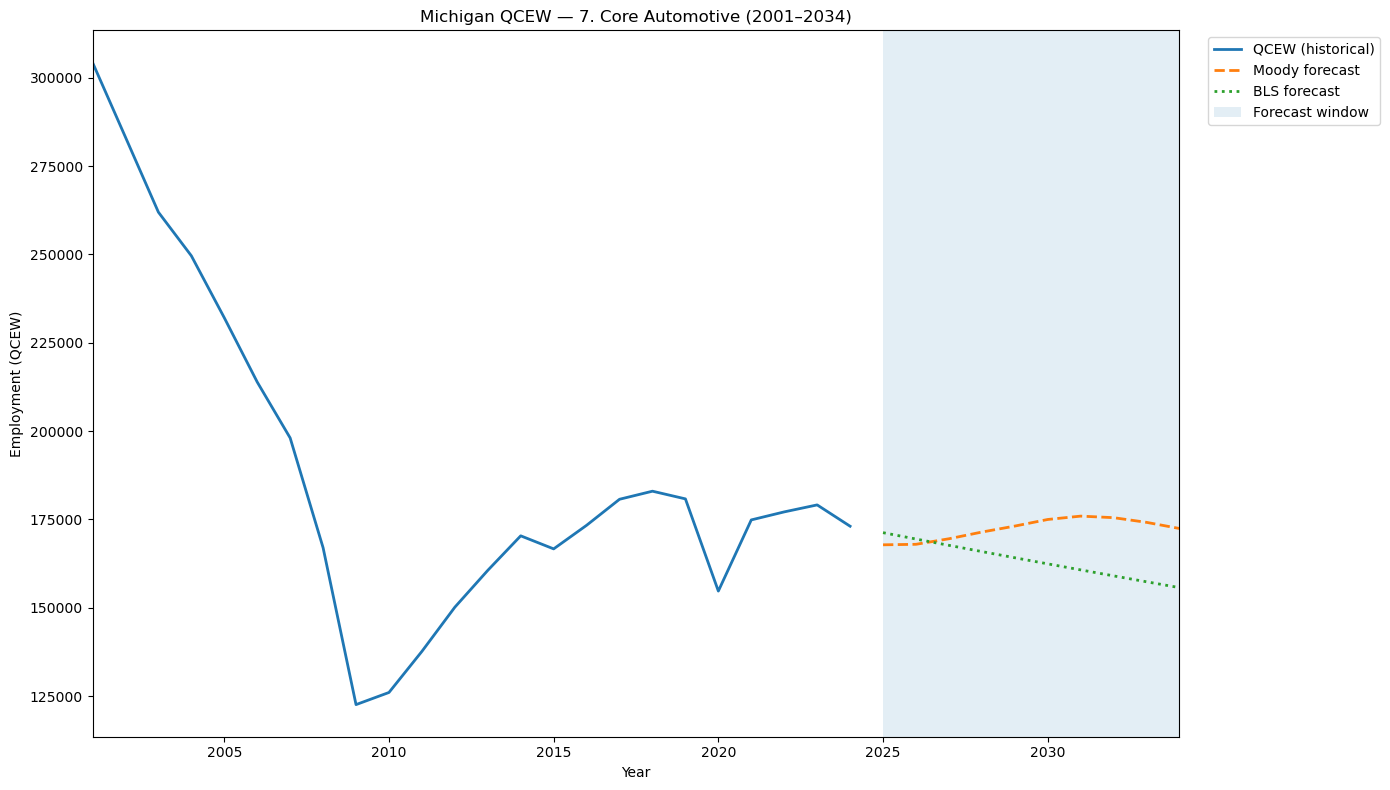

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_8_compare_2001_2034.png


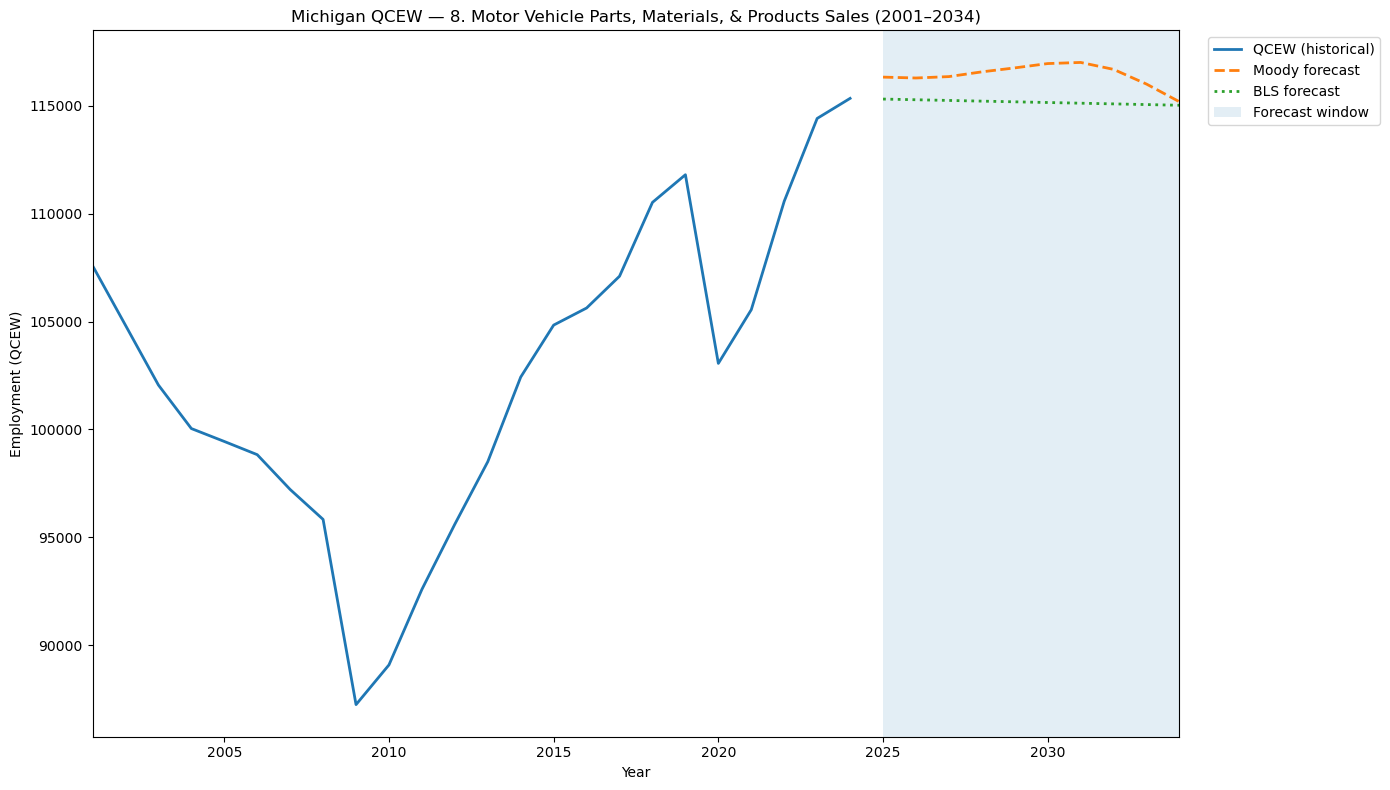

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_9_compare_2001_2034.png


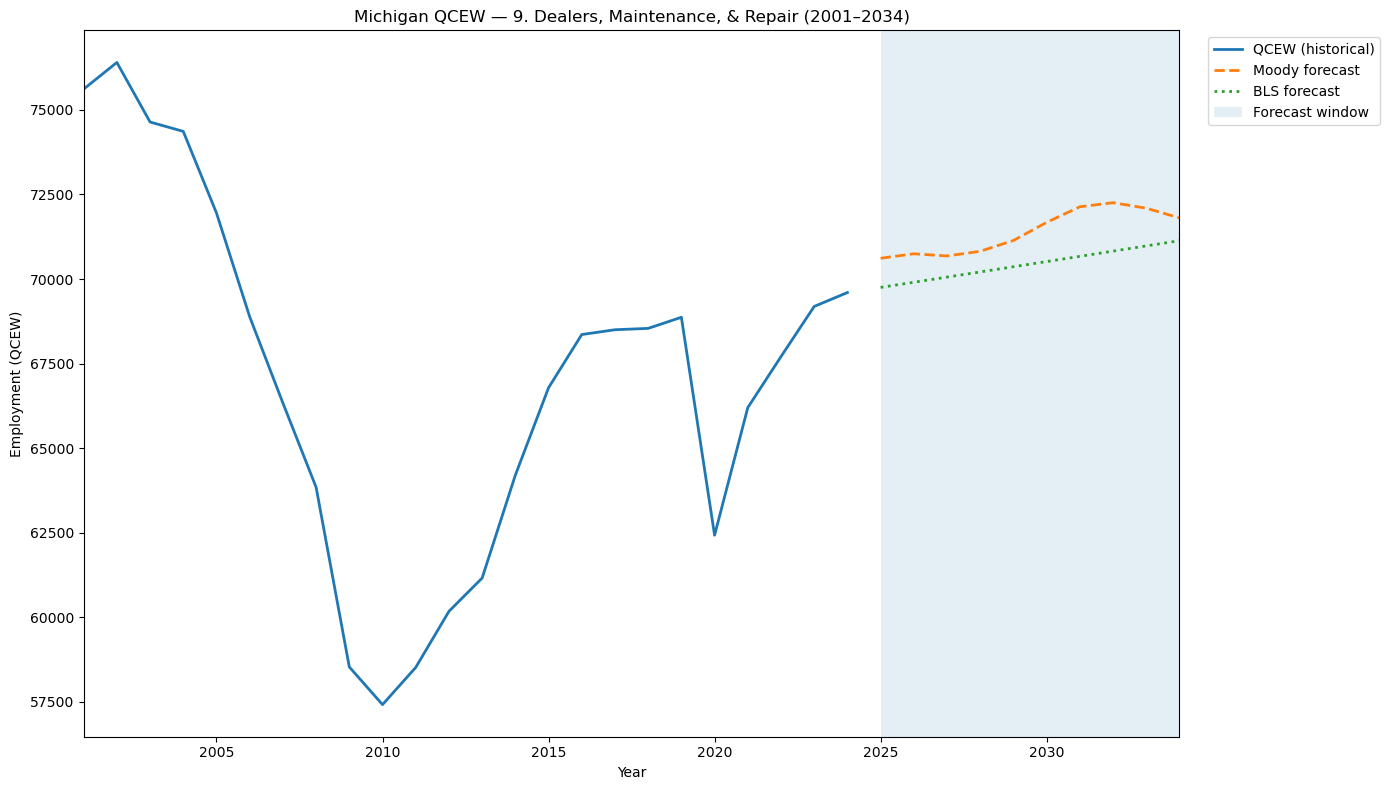

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segment_10_compare_2001_2034.png


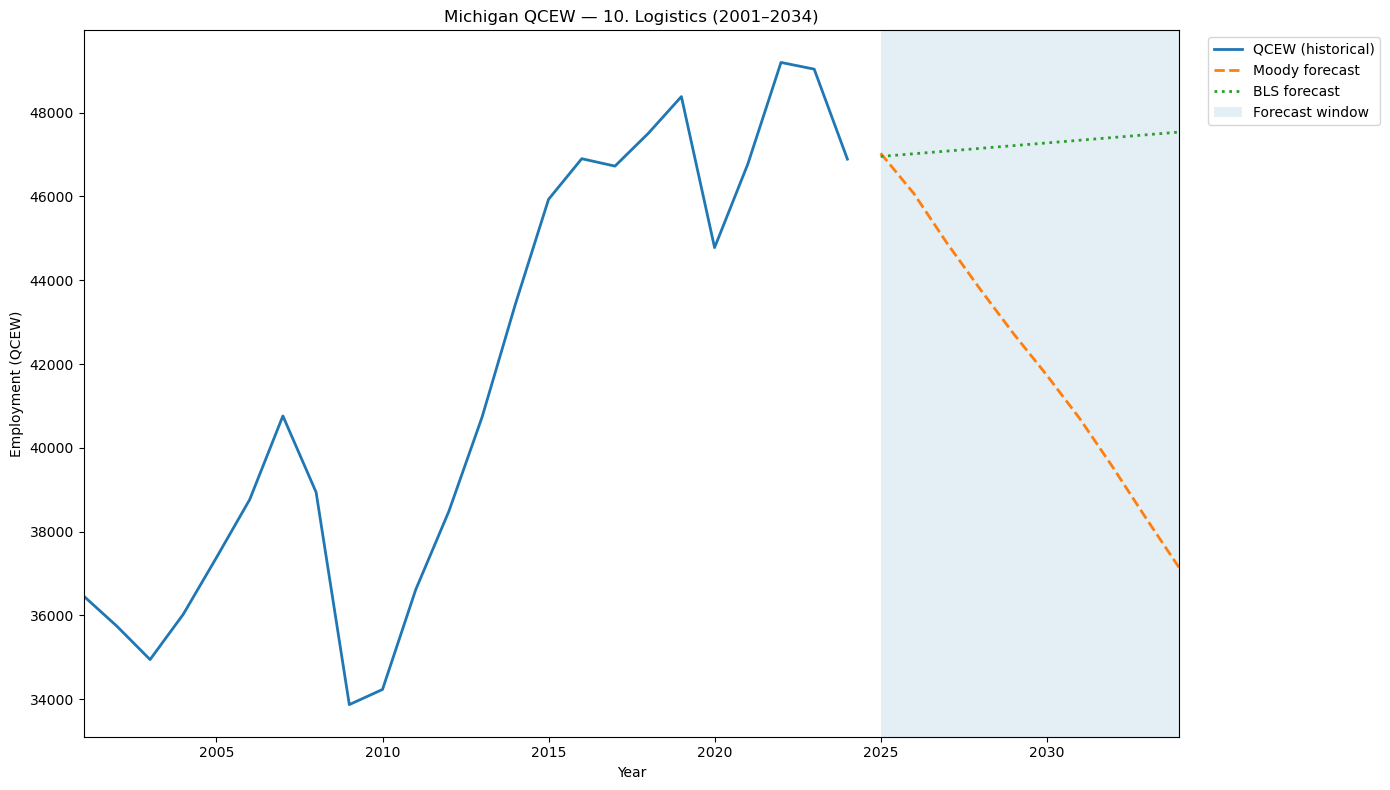

In [5]:

seg_label_col = "segment_name" if "segment_name" in seg.columns else ("segment_label" if "segment_label" in seg.columns else None)
if seg_label_col is None:
    raise KeyError("segment_name/segment_label not found in segment compare file.")

for seg_id, g in seg.groupby("segment_id", sort=True):
    seg_label = g[seg_label_col].dropna().iloc[0] if not g[seg_label_col].dropna().empty else f"Segment {seg_id}"
    _plot_group_compare(
        sub=g,
        title=f"Michigan QCEW — {seg_label} (2001–2034)",
        out_png=FIG_DIR / f"mi_qcew_segment_{seg_id}_compare_2001_2034.png",
        figsize=(14,8)
    )
